In [2]:
# Import packages
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from datetime import date 
import geopandas as gpd
import pandas as pd
import time


In [151]:
# Open browser
service = Service("chromedriver.exe")
driver= webdriver.Chrome(service=service)
driver.maximize_window()

## 1- Open the Universities page

In [152]:
imp_wait_time=10
exp_wait_time=2
base_url = "https://istatistik.yok.gov.tr"
driver.get(base_url)
WebDriverWait(driver, imp_wait_time).until(EC.element_to_be_clickable((By.XPATH, "//span[text()='Birim İstatistikleri']"))).click()
WebDriverWait(driver, imp_wait_time).until(EC.element_to_be_clickable((By.XPATH, "//span[text()='Genel Bilgiler']"))).click()
WebDriverWait(driver, imp_wait_time).until(EC.element_to_be_clickable((By.XPATH, "//span[text()='Üniversiteler']"))).click()

## 2-Fill the df

In [153]:
df=pd.DataFrame(columns=["uni_name","foundation_year","type","city","region","year"])

We define a function to parse data for each year.

In [154]:
def add_year(df,year,driver):
    WebDriverWait(driver, imp_wait_time).until(EC.element_to_be_clickable((By.XPATH, "//button[text()='Raporu Getir']"))).click()# Click bring report button
    time.sleep(exp_wait_time)
    has_next_page = True
  
    while has_next_page:   
        time.sleep(exp_wait_time)
        div = driver.find_elements(by=By.XPATH, value="//div[@class='z-center-body']//div[@class='z-listbox-body']")[0]
        tbody = div.find_elements(by=By.XPATH, value=".//tbody")[0]
        driver.implicitly_wait(imp_wait_time)
        rows = tbody.find_elements(by=By.XPATH, value=".//tr")

        for row in rows:
            driver.implicitly_wait(imp_wait_time)
           
            cells =  row.find_elements(by=By.XPATH, value="./td/div")         
            data = [cells[j].get_attribute("innerText")  for j in range(len(df.columns)-1)] +[ int(year)   ]
            df.loc[len(df)]=data
   
        next_page_link = WebDriverWait(driver, imp_wait_time).until(EC.presence_of_element_located((By.XPATH, "//a[@class='z-paging-button z-paging-next']")))
        ActionChains(driver).move_to_element(next_page_link)   
        has_next_page =  not (next_page_link.get_attribute("disabled") == "true")
        if  has_next_page:
            next_page_link.click()  
        
       

Using the helper add_year function we fill the df.

In [155]:
WebDriverWait(driver, imp_wait_time).until(EC.presence_of_element_located((By.XPATH, "//button[text()='Yıl Seçiniz']"))).click()
time.sleep(exp_wait_time)
n_year = len(driver.find_elements(by=By.XPATH, value="//div[@class='z-listcell-content']"))

for n in range(1,n_year): 
    year_table = driver.find_elements(by=By.XPATH, value="//table")[-1]
    driver.implicitly_wait(imp_wait_time)
    year_radio_button = year_table.find_elements(by=By.XPATH, value=".//div[@class='z-listcell-content']")[n]
    driver.implicitly_wait(imp_wait_time)
    year = year_radio_button.get_attribute("innerText").strip()
    year_radio_button.click()
    driver.implicitly_wait(imp_wait_time)
    WebDriverWait(driver, imp_wait_time).until(EC.presence_of_element_located((By.XPATH, "//button[text()='Seç']"))).click()
    time.sleep(exp_wait_time)
    if year!="GÜNCEL":
        add_year(df,year,driver)
 
   # WebDriverWait(driver, imp_wait_time).until(EC.presence_of_element_located((By.XPATH, "//button[text()='Sil']"))).click()#Click "clear year" button
    WebDriverWait(driver, imp_wait_time).until(EC.presence_of_element_located((By.XPATH, "//button[text()='Yıl Seçiniz']"))).click()
    time.sleep(exp_wait_time)

Let's check the shape of df

In [156]:
df.shape

(4332, 6)

Let's check content (setting index for easier visualization)

In [157]:
df.set_index(["year","uni_name"])

foundation_year  \
year uni_name                                                             
2023 ABDULLAH GÜL ÜNİVERSİTESİ                               21.07.2010   
     ACIBADEM MEHMET ALİ AYDINLAR ÜNİVERSİTESİ               18.05.2007   
     ADANA ALPARSLAN TÜRKEŞ BİLİM VE TEKNOLOJİ ÜNİVE...      14.04.2011   
     ADIYAMAN ÜNİVERSİTESİ                                   17.03.2006   
     AFYON KOCATEPE ÜNİVERSİTESİ                             11.07.1992   
...                                                                 ...   
1984 TRAKYA ÜNİVERSİTESİ                                     20.07.1982   
     ULUDAĞ ÜNİVERSİTESİ                                     11.04.1975   
     YILDIZ TEKNİK ÜNİVERSİTESİ                              20.07.1982   
     YILDIZ ÜNİVERSİTESİ                                     01.01.1982   
     YÜZÜNCÜ YIL ÜNİVERSİTESİ                                20.07.1982   

                                                           type  \
year uni_name                                                     
2023 ABDULLAH GÜL ÜNİVERSİTESİ                           DEVLET   
     ACIBADEM MEHMET ALİ AYDINLAR ÜNİVERSİTESİ            VAKIF   
     ADANA ALPARSLAN TÜRKEŞ BİLİM VE TEKNOLOJİ ÜNİVE...  DEVLET   
     ADIYAMAN ÜNİVERSİTESİ                               DEVLET   
     AFYON KOCATEPE ÜNİVERSİTESİ                         DEVLET   
...                                                         ...   
1984 TRAKYA ÜNİVERSİTESİ                                 DEVLET   
     ULUDAĞ ÜNİVERSİTESİ                                 DEVLET   
     YILDIZ TEKNİK ÜNİVERSİTESİ                          DEVLET   
     YILDIZ ÜNİVERSİTESİ                                 DEVLET   
     YÜZÜNCÜ YIL ÜNİVERSİTESİ                            DEVLET   

                                                                   city  \
year uni_name                                                             
2023 ABDULLAH GÜL ÜNİVERSİTESİ                                  KAYSERİ   
     ACIBADEM MEHMET ALİ AYDINLAR ÜNİVERSİTESİ                 İSTANBUL   
     ADANA ALPARSLAN TÜRKEŞ BİLİM VE TEKNOLOJİ ÜNİVE...           ADANA   
     ADIYAMAN ÜNİVERSİTESİ                                     ADIYAMAN   
     AFYON KOCATEPE ÜNİVERSİTESİ                         AFYONKARAHİSAR   
...                                                                 ...   
1984 TRAKYA ÜNİVERSİTESİ                                         EDİRNE   
     ULUDAĞ ÜNİVERSİTESİ                                          BURSA   
     YILDIZ TEKNİK ÜNİVERSİTESİ                                İSTANBUL   
     YILDIZ ÜNİVERSİTESİ                                       İSTANBUL   
     YÜZÜNCÜ YIL ÜNİVERSİTESİ                                       VAN   

                                                                    region  
year uni_name                                                               
2023 ABDULLAH GÜL ÜNİVERSİTESİ                                  İÇ ANADOLU  
     ACIBADEM MEHMET ALİ AYDINLAR ÜNİVERSİTESİ                     MARMARA  
     ADANA ALPARSLAN TÜRKEŞ BİLİM VE TEKNOLOJİ ÜNİVE...            AKDENİZ  
     ADIYAMAN ÜNİVERSİTESİ                               GÜNEYDOĞU ANADOLU  
     AFYON KOCATEPE ÜNİVERSİTESİ                                       EGE  
...                                                                    ...  
1984 TRAKYA ÜNİVERSİTESİ                                           MARMARA  
     ULUDAĞ ÜNİVERSİTESİ                                           MARMARA  
     YILDIZ TEKNİK ÜNİVERSİTESİ                                    MARMARA  
     YILDIZ ÜNİVERSİTESİ                                           MARMARA  
     YÜZÜNCÜ YIL ÜNİVERSİTESİ                                 DOĞU ANADOLU  

[4332 rows x 4 columns]

We can convert city from uppercase to title from for compatibility with other dataframes.

In [240]:
# this code is necessary to fix issue for 'İ'
#By normalizing the string using NFC (Normalization Form Canonical Composition)
# we ensure that the special character 'İ' is represented as a single character
def normalize_string(s):
    return unicodedata.normalize('NFC', s)
df["city"] = df["city"].apply(lambda x: normalize_string(x))
df.head(2)

,uni_name,foundation_year,type,city,region,year
0,ABDULLAH GÜL ÜNİVERSİTESİ,21.07.2010,DEVLET,KAYSERİ,İÇ ANADOLU,2023
1,ACIBADEM MEHMET ALİ AYDINLAR ÜNİVERSİTESİ,18.05.2007,VAKIF,İSTANBUL,MARMARA,2023


Let's check number of unique city names (it should be 81).

In [241]:
df["city"].nunique()

81

In [5]:
lower_map = {ord(u'I'): u'ı',ord(u'İ'): u'i' }
def lower_fix_letter_i(x):
    return x.translate(lower_map)
def title_fix_letter_i(x):
    if x[0]=="i":
        x="İ"+x[1:]
    return x

df["city"] = df["city"].apply(lower_fix_letter_i)
df["city"] = df["city"].apply(title_fix_letter_i)
df["city"] = df["city"].apply(str.title)

Finally, we can save df.

In [6]:
df.to_csv("df_years_universities.csv",index=False)

### 4- Plotting total number of universities by years

In [129]:
df_year_counts=df[["year","type"]].value_counts().to_frame()
df_year_counts=df_year_counts.reset_index().pivot_table(index='year', columns='type', values='count', fill_value=0)
df_year_counts.head()

type,DEVLET,VAKIF,VAKIF MYO
year,,,
1984,19,0,0
1985,19,1,0
1986,19,1,0
1987,19,1,0
1988,19,1,0


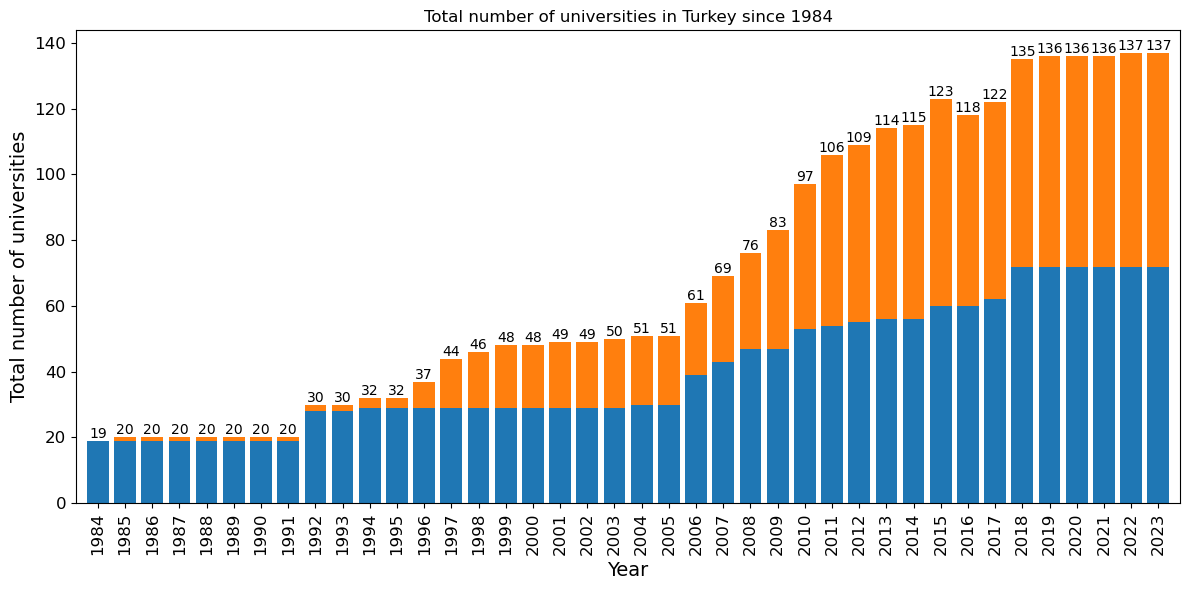

In [130]:
fig, ax = plt.subplots(1,figsize=(12,6))
x_vals= range(1984,2024)
plt.xticks(x_vals, rotation="vertical")
ax.tick_params(axis='both', which='major', labelsize=12)

bottom = np.zeros(40)
for boolean, count in df_year_counts[["DEVLET","VAKIF"]].items():
    p = ax.bar(x = x_vals,  height=count,  bottom=bottom)
    bottom += count

plt.ylabel("Total number of universities",size=14)
plt.xlabel("Year",size=14)
for x, height in zip(range(1984, 2024),  df_year_counts[["DEVLET","VAKIF"]].sum(axis=1)):
    ax.text(x, height, str(height), ha="center", va="bottom", fontsize=10)
plt.title("Total number of universities in Turkey since 1984")

plt.tight_layout()
ax.margins(x=0.01)
fig.savefig('myimage.jpeg', format='jpeg', dpi=300)